In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# import zipfile
# zip_ref = zipfile.ZipFile("/content/drive/MyDrive/RGB_KITTI.zip", 'r')
# zip_ref.extractall("/content")
# zip_ref.close()

In [ ]:
# import zipfile
# zip_ref = zipfile.ZipFile("/content/drive/MyDrive/nyu_data.zip", 'r')
# zip_ref.extractall("/content")
# zip_ref.close()

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Conv2DTranspose

In [ ]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model
# from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline
import tensorflow as tf

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

/usr/local/lib/python3.7/dist-packages/keras/backend.py:414: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [ ]:
# GRADED FUNCTION: identity_block

def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(F2,kernel_size=(f,f),strides=(1,1),padding='same',kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=-1)(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3,(1,1),strides=(1,1),padding='valid',kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=-1)(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [ ]:
# GRADED FUNCTION: convolutional_block

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(filters =F1, kernel_size =(1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(filters =F2, kernel_size =(f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters =F3, kernel_size =(1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters =F3, kernel_size =(1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut]) 
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [ ]:

def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 1)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 1)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
   
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
model = ResNet50(input_shape = (240, 320, 3))
print(model.input_shape)

(None, 240, 320, 3)


In [ ]:
# loading resnet50 model using tensorflow
model2=tf.keras.applications.ResNet50(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=(240, 320, 3), pooling=None, 
)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
for i in range(1,len(model.layers)):
#     print(i, model.layers[i].output_shape, model2.layers[i].output_shape)
#     print(model.layers[i],model2.layers[i])
    try:
        weights = model2.layers[i].get_weights()
        model.layers[i].set_weights(weights)
        print(i)
    except Exception as e:
        print("pass",i)
        pass

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
pass 45
pass 46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
pass 87
pass 88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
pass 149
pass 150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174


In [ ]:
# physical_devices = tf.config.list_physical_devices("GPU")
# print("no of gpu: ",physical_devices)

In [ ]:
print(model.output_shape)

(None, 30, 40, 2048)


In [ ]:
def depth_model(model_output):

    '''

      make depth model after resnet50 model( feature extractor ) 
        1. increasing size(double) of previous layer output using bilinear upsampling 2d layer 
        2. adding convolution layer after upsamling layer
        3. repeat step 2nd and step 3rd 4 times 
    ''' 
    f1_depth=tf.keras.layers.Conv2DTranspose(512,(2,2),name='conv1_d',activation='relu', strides = 2)(model.output)
    
    
    f2_depth=tf.keras.layers.Conv2DTranspose(128,(2,2), strides = 2, name='conv2_d',activation='relu')(f1_depth)

    f3_depth=tf.keras.layers.Conv2DTranspose(64,(2,2),strides = 2,name='conv3_d',activation='relu')(f2_depth)

    f4_depth=tf.keras.layers.Conv2DTranspose(1,(2,2),strides = 2, name="conv4_d",activation='relu')(f3_depth)



    '''
      Apply semi dense up skip connection between f_in, f1, f2, f3 layer
      f_out=h(f_in)+sumation_of_(h(f(i))) where i belong to (1,n)
    '''
    #add_shape  of f4 output
    f4_depth_shape_x_y = (240,320)
    f4_depth_filters=f4_depth.shape[3]

    # BASE INPUT LAYER UPSAMPLING
    bilinear_upsampling_in = tf.keras.layers.experimental.preprocessing.Resizing(f4_depth_shape_x_y[0], f4_depth_shape_x_y[1], interpolation='bilinear')(model_output)
    f_depth_out_in=tf.keras.layers.Conv2D(f4_depth_filters,(1,1),name='resize_filter_conv_in',activation='relu')(bilinear_upsampling_in)

    # FIRST LAYER BILINEAR UPsAMPLING
    bilinear_upsampling_1 = tf.keras.layers.experimental.preprocessing.Resizing(f4_depth_shape_x_y[0], f4_depth_shape_x_y[1], interpolation='bilinear')(f1_depth)
    f_depth_out1 = tf.keras.layers.Conv2D(f4_depth_filters,(1,1),name='resize_filter_conv1',activation='relu')(bilinear_upsampling_1)

    #SECOND LAYER BILINEAR UPSAMPLING
    bilinear_upsampling_2 = tf.keras.layers.experimental.preprocessing.Resizing(f4_depth_shape_x_y[0], f4_depth_shape_x_y[1], interpolation='bilinear')(f2_depth)
    f_depth_out2 = tf.keras.layers.Conv2D(f4_depth_filters,(1,1),name='resize_filter_conv2',activation='relu')(bilinear_upsampling_2)

    # 3rd LAYER UPSAMPLING
    bilinear_upsampling_3 = tf.keras.layers.experimental.preprocessing.Resizing(f4_depth_shape_x_y[0], f4_depth_shape_x_y[1], interpolation='bilinear')(f3_depth)
    f_depth_out3 = tf.keras.layers.Conv2D(f4_depth_filters,(1,1),name='resize_filter_conv3',activation='relu')(bilinear_upsampling_3)
    # bilinear_upsampling_3 = tf.keras.layers.experimental.preprocessing.Resizing(f4.shape[1], f4.shape[2], interpolation='bilinear')(f3)
    # f_out3 = tf.keras.layers.Conv2D(f4_filters,(1,1),name='resize_filter_conv3')(bilinear_upsampling_3)

    #F_out LAYER UPSAMPLING
    bilinear_upsampling_4 = tf.keras.layers.experimental.preprocessing.Resizing(f4_depth_shape_x_y[0], f4_depth_shape_x_y[1], interpolation='bilinear')(f4_depth)
    f_depth_out4 = tf.keras.layers.Conv2D(f4_depth_filters,(1,1),name='resize_filter_conv4',activation='relu')(bilinear_upsampling_4)

    
    ''' Applying formulae for semi dense up skip connection '''
    f_depth_out=tf.keras.layers.Add()([f_depth_out_in,f_depth_out1,f_depth_out2,f_depth_out3,f_depth_out4])

    # put the code below out of this function
    ''' Building depth model from Vgg16 to f_out'''
    from tensorflow.keras import Model    
    depth_model=Model(inputs=model.input,outputs=f_depth_out)
    depth_model.summary()
    return depth_model




In [ ]:
"""def semantic_model(model_output):

    '''
      make semantic model after resnet50 model( feature extractor ) 
        1. increasing size(double) of previous layer output using bilinear upsampling 2d layer 
        2. adding convolution layer after upsamling layer
        3. repeat step 2nd and step 3rd 4 times 
    ''' 
    x1_semantic=tf.keras.layers.UpSampling2D(size=(2,2) , data_format=None, interpolation='bilinear',name='upsampling1')(model_output)
    f1_semantic=tf.keras.layers.Conv2D(64,(1,1),padding='same',name='conv1')(x1_semantic)

    x2_semantic=tf.keras.layers.UpSampling2D(size= (2,2),data_format=None,interpolation='bilinear',name='upsampling2')(f1_semantic)
    f2_semantic=tf.keras.layers.Conv2D(32,(1,1),padding='same',name='conv2')(x2_semantic)

    x3_semantic=tf.keras.layers.UpSampling2D(size=(2,2),data_format=None,interpolation='bilinear',name='upsampling3')(f2_semantic)
    f3_semantic=tf.keras.layers.Conv2D(16,(1,1),padding='same',name='conv3')(x3_semantic)

    x4_semantic=tf.keras.layers.UpSampling2D(size= (2,2), data_format=None, interpolation='bilinear',name='upsampling4')(f3_semantic)
    f4_semantic=tf.keras.layers.Conv2D(3,(1,1),padding='same',name="conv4")(x4_semantic)
    
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
#     print("output)
    '''
      Apply semi dense up skip connection between f_in, f1, f2, f3 layer
      f_out=h(f_in)+summation_of_(h(f(i))) where i belong to (1,n)
    '''
    #add_shape  of f4 output
    f4_semantic_shape_x_y = (240,320)
    f4_semantic_filters=f4_semantic.shape[3]
    
    # BASE INPUT LAYER UPSAMPLING
    bilinear_upsampling_in = tf.keras.layers.experimental.preprocessing.Resizing(f4_semantic_shape_x_y[0], f4_semantic_shape_x_y[1], interpolation='bilinear')(model_output)
    f_semantic_out_in=tf.keras.layers.Conv2DTranspose(f4_semantic_filters,(1,1),name='resize_filter_conv_in',activation='relu')(bilinear_upsampling_in)

    # FIRST LAYER BILINEAR UPsAMPLING
    bilinear_upsampling_1 = tf.keras.layers.experimental.preprocessing.Resizing(f4_semantic_shape_x_y[0], f4_semantic_shape_x_y[1], interpolation='bilinear')(f1_semantic)
    f_semantic_out1 =tf.keras.layers.Conv2DTranspose(f4_semantic_filters,(1,1),name='resize_filter_conv1',activation='relu')(bilinear_upsampling_1)

    #SECOND LAYER BILINEAR UPSAMPLING
    bilinear_upsampling_2 = tf.keras.layers.experimental.preprocessing.Resizing(f4_semantic_shape_x_y[0], f4_semantic_shape_x_y[1], interpolation='bilinear')(f2_semantic)
    f_semantic_out2 = tf.keras.layers.Conv2DTranspose(f4_semantic_filters,(1,1),name='resize_filter_conv2',activation='relu')(bilinear_upsampling_2)

    # 3rd LAYER UPSAMPLING
    bilinear_upsampling_3 = tf.keras.layers.experimental.preprocessing.Resizing(f4_semantic_shape_x_y[0], f4_semantic_shape_x_y[1], interpolation='bilinear')(f3_semantic)
    f_semantic_out3 = tf.keras.layers.Conv2DTranspose(f4_semantic_filters,(1,1),name='resize_filter_conv3',activation='relu')(bilinear_upsampling_3)
    # bilinear_upsampling_3 = tf.keras.layers.experimental.preprocessing.Resizing(f4.shape[1], f4.shape[2], interpolation='bilinear')(f3)
    # f_out3 = tf.keras.layers.Conv2D(f4_filters,(1,1),name='resize_filter_conv3')(bilinear_upsampling_3)

    #F_out LAYER UPSAMPLING
    bilinear_upsampling_4 = tf.keras.layers.experimental.preprocessing.Resizing(f4_semantic_shape_x_y[0], f4_semantic_shape_x_y[1], interpolation='bilinear')(f4_semantic)
    f_semantic_out4 = tf.keras.layers.Conv2DTranspose(f4_semantic_filters,(1,1),name='resize_filter_conv4',activation='relu')(bilinear_upsampling_4)

    
    ''' Applying formulae for semi dense up skip connection '''
#     f_semantic_out = f_semantic_out_in + f_semantic_out1 + f_semantic_out2 + f_semantic_out3 + f_semantic_out4
    f_depth_out=tf.keras.layers.Add()([f_semantic_out_in,f_semantic_out1,f_semantic_out2,f_semantic_out3,f_semantic_out4])



    ''' Building semantic model from Vgg16 to f_out'''
    from tensorflow.keras import Model
    semantic_model=Model(inputs=model.input,outputs=f_semantic_out)
    semantic_model.summary()
    return semantic_model
"""



'def semantic_model(model_output):\n\n    \'\'\'\n      make semantic model after resnet50 model( feature extractor ) \n        1. increasing size(double) of previous layer output using bilinear upsampling 2d layer \n        2. adding convolution layer after upsamling layer\n        3. repeat step 2nd and step 3rd 4 times \n    \'\'\' \n    x1_semantic=tf.keras.layers.UpSampling2D(size=(2,2) , data_format=None, interpolation=\'bilinear\',name=\'upsampling1\')(model_output)\n    f1_semantic=tf.keras.layers.Conv2D(64,(1,1),padding=\'same\',name=\'conv1\')(x1_semantic)\n\n    x2_semantic=tf.keras.layers.UpSampling2D(size= (2,2),data_format=None,interpolation=\'bilinear\',name=\'upsampling2\')(f1_semantic)\n    f2_semantic=tf.keras.layers.Conv2D(32,(1,1),padding=\'same\',name=\'conv2\')(x2_semantic)\n\n    x3_semantic=tf.keras.layers.UpSampling2D(size=(2,2),data_format=None,interpolation=\'bilinear\',name=\'upsampling3\')(f2_semantic)\n    f3_semantic=tf.keras.layers.Conv2D(16,(1,1),paddin

In [ ]:
depth_model= depth_model(model.output)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 246, 326, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 120, 160, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

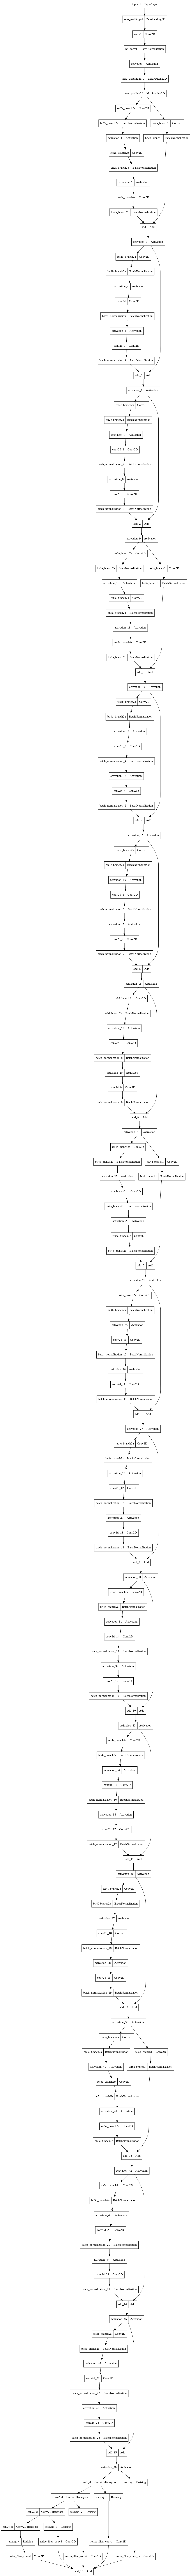

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(depth_model)

In [ ]:
import numpy as np
import cv2
from tensorflow.keras.utils import Sequence
import tensorflow as tf
import os
import json


class DataGenerator(Sequence):
    def __init__(self, x_data, y_depth,
                 batch_size=32, dim=(320,240),
                 shuffle=True):
        self.x_data = x_data
        self.y_depth = y_depth
        # self.y_semantic = y_semantic
        self.batch_size = batch_size
        self.dim = dim


    def __len__(self):
        return int(np.floor(len(self.x_data) / self.batch_size))


    def __getitem__(self, index):
        start_index = index * self.batch_size
        x_train = []
        y_train_depth = []
        # y_train_semantic = []
        i = start_index - 1
        while len(x_train) < self.batch_size:
            try:
                img = cv2.imread(self.x_data[i % len(self.x_data)])
                img = cv2.resize(img,(320, 240))
                # img = np.array(img, dtype = np.float32)
                img = img / 255.0
              
                y_depth = cv2.imread(self.y_depth[i%len(self.y_depth)])
                y_depth = cv2.cvtColor(y_depth,cv2.COLOR_BGR2GRAY)
                y_depth = cv2.resize(y_depth, (320, 240))
                # y_depth = np.array(y_depth, dtype = np.float32)
                y_depth = y_depth / 255.0
                # print(y_depth)
                x_train.append(img)
                y_train_depth.append(y_depth)
                i += 1
            except Exception as err:
                print(err)
                continue

        return np.array(x_train),np.array(y_train_depth)

In [ ]:
# img_dir = '/content/RGB_KITTI'
# depth_dir = '/content/output'
# img_paths = []
# depth_paths = []
# for i in os.listdir(depth_dir):
#   # print(i)
#   for j in os.listdir(depth_dir + '/' + i + '/2011_09_26/' + i):
#     # print(j)
#     for k in os.listdir(depth_dir + '/' + i + '/2011_09_26/' + i + '/' + j):
#       depth_path = depth_dir + '/' + i + '/2011_09_26/' + i + '/' + j + '/' + k
#       img_path = img_dir + '/' + i + '/2011_09_26/' + i + '/' + j + '/data' + '/' + k
#       depth_paths.append(depth_path)
#       img_paths.append(img_path)
# img_paths = np.array(img_paths)
# depth_paths = np.array(depth_paths)

In [ ]:
# import numpy as np
# import os
# import cv2
# dir = '/content/data/nyu2_train'
# img_paths = []
# depth_paths = []
# for i in os.listdir(dir):
#   for j in os.listdir(dir + '/' + i):
#     if len(img_paths) >= 25000:
#       break
#     if j[-4:] == '.jpg':
#       img_path = dir + '/' + i + '/' + j
#       depth_path = dir + '/' + i + '/' + j[:-4] + '.png'
#       img_paths.append(img_path)
#       depth_paths.append(depth_path)


# img_paths = np.array(img_paths)
# depth_paths = np.array(depth_paths)

In [ ]:
# print(img_paths)
# print(len(depth_paths))

['/content/data/nyu2_train/cafe_0001b_out/82.jpg'
 '/content/data/nyu2_train/cafe_0001b_out/58.jpg'
 '/content/data/nyu2_train/cafe_0001b_out/78.jpg' ...
 '/content/data/nyu2_train/bathroom_0049_out/17.jpg'
 '/content/data/nyu2_train/bathroom_0049_out/20.jpg'
 '/content/data/nyu2_train/bathroom_0049_out/22.jpg']
25000


In [ ]:
# train_data = DataGenerator(img_paths, depth_paths, batch_size=4, dim=(320, 240))

In [ ]:
# def depth_aware_loss(y_true, y_pred):
#   i = y_true
#   y_true = (tf.convert_to_tensor(y_true, dtype = tf.float32) * 255.0) + 1
#   y_pred = (tf.convert_to_tensor(y_pred, dtype = tf.float32) * 255.0) + 1
#   y_true = tf.clip_by_value(y_true, 2.0, 255.0)
#   y_pred = tf.clip_by_value(y_pred, 2.0, 255.0)
#   lambda_d = 1 - (tf.math.minimum(tf.math.log(y_true), tf.math.log(y_pred)) / tf.math.maximum(tf.math.log(y_true), tf.math.log(y_pred)))
#   loss = tf.reduce_mean((i + lambda_d) * tf.math.abs(y_true - y_pred))
#   return loss

In [ ]:
def depth_gradient_loss(y_true, y_pred):

    y_true = tf.image.convert_image_dtype(y_true, dtype=tf.float32)
    y_true = tf.expand_dims(y_true, axis = 3)
    y_pred = tf.image.convert_image_dtype(y_pred, dtype = tf.float32)
    y_pred = tf.expand_dims(y_pred, axis = 3)
    #y_true edges

    sobel_true = tf.image.sobel_edges(y_true)
    sobel_true_h = sobel_true[0, :, :, :, 0]
    sobel_true_w = sobel_true[0, :, :, :, 1]
    #y_pred edges
    sobel_pred = tf.image.sobel_edges(y_pred)
    sobel_pred_h = sobel_pred[0, :, :, :, 0]
    sobel_pred_w = sobel_pred[0, :, :, :, 1]
    #loss
    # y_true = tf.squeeze(y_true, axis = 0)
    # t_pred = tf.squeeze(y_pred, axis = 0)
    loss_depth = tf.reduce_mean(tf.math.abs(sobel_pred_h - sobel_true_h) + tf.math.abs(sobel_pred_w - sobel_true_w))
#     N = y_true.shape[1]
#     loss_depth = loss_depth/(N * N)
    return loss_depth

In [ ]:
def depth_aware_loss(y_true, y_pred):
  i = y_true
  y_true = (tf.convert_to_tensor(y_true, dtype = tf.float32) * 255.0)
  y_pred = (tf.convert_to_tensor(y_pred, dtype = tf.float32) * 255.0)
  y_true = tf.clip_by_value(y_true, 1.0, 255.0)
  y_pred = tf.clip_by_value(y_pred, 1.0, 255.0)
  lambda_d = 1 - (tf.math.minimum(tf.math.log(y_true), tf.math.log(y_pred)) / tf.math.maximum(tf.math.log(y_true), tf.math.log(y_pred)))
  loss = tf.reduce_mean((i + lambda_d) * tf.math.abs(y_true - y_pred))
  return loss

In [ ]:
def combined_depth_loss(y_true,y_pred):
    
    loss1=depth_aware_loss(y_true,y_pred)
    loss2 = depth_gradient_loss(y_true,y_pred)
    loss=loss1+loss2
    return loss


In [ ]:
from tensorflow.keras.optimizers import Adam
optimizer=Adam(learning_rate=0.0001)

In [ ]:
depth_model.compile(optimizer=optimizer,loss= combined_depth_loss)

In [ ]:
from tensorflow.keras.callbacks import (  
    ModelCheckpoint,
    TensorBoard
)

In [ ]:
# os.mkdir("/content/drive/MyDrive/depth_single")
# os.mkdir("/content/drive/MyDrive/depth_KITTI")

In [ ]:
callbacks = [tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/that_was_deep/checkpoints/train_{epoch}.tf", verbose = 1,
                                                save_weights_only=True)]    

In [ ]:
depth_model.load_weights('/content/drive/MyDrive/depth_weights/train_48.tf')

In [ ]:
# depth_model.fit(train_data, epochs = 50, verbose = 1, callbacks = callbacks) 

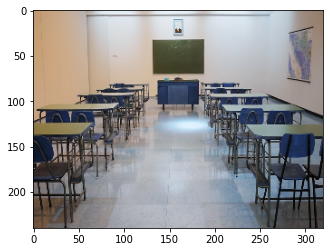

In [ ]:
img = cv2.imread("/content/drive/MyDrive/depth_weights/img.jpeg")
img = cv2.resize(img, (320,240))
img = np.expand_dims(img, axis =0)
plt.imshow(img[0])

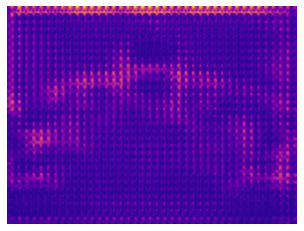

In [ ]:
output = depth_model.predict(img)
plt.imshow(output[0][...,0],cmap='plasma')
plt.axis('off')
plt.show()

In [ ]:
# img = cv2.imread("/content/drive/MyDrive/depth_weights/img.jpeg")
# img = cv2.resize(img, (320,240))
# img = np.expand_dims(img, axis =0)
# plt.imshow(img[0])
path = '/content/drive/MyDrive/data/'
op_path = '/content/drive/MyDrive/output_data/'
imgs = os.listdir('/content/drive/MyDrive/data')
for name in imgs:
    img = cv2.imread(path+name)
    img = cv2.resize(img, (320,240))
    img = np.expand_dims(img, axis =0)
    output = depth_model.predict(img)
    # plt.imshow(output[0][...,0],cmap='plasma')
    # plt.axis('off')
    # plt.show()
    cv2.imwrite(op_path+"output_depth"+name, output[0][...,0])

error: ignored

In [ ]:
# Create a VideoCapture object and read from input file
cap = cv2.VideoCapture('/content/drive/MyDrive/data/videoplayback.mp4')
   
# Check if camera opened successfully
if (cap.isOpened()== False): 
  print("Error opening video  file")

i=0
# Read until video is completed
while(cap.isOpened()):

  # Capture frame-by-frame
  ret, img = cap.read()
  i+=1
  if ret == True:
    img = cv2.resize(img, (320,240))
    img = np.expand_dims(img, axis =0)
    output = depth_model.predict(img)
    # plt.imshow(output[0][...,0],cmap='plasma')
    # plt.axis('off')
    # plt.show()
    cv2.imwrite(op_path+"output_depth"+str(i)+".jpg", output[0][...,0])
   
   
  # Break the loop
  else: 
    break
   
# When everything done, release 
# the video capture object
cap.release()
   
# Closes all the frames
cv2.destroyAllWindows()

KeyboardInterrupt: ignored